In [52]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 

## Normal with Early to Late

In [53]:
# Load the adjacency matrix into a numpy array.
normal_mat = np.loadtxt('../Normal.txt', dtype=int)
for i in range(0,70):
        normal_mat[i][i] = 0
G = nx.from_numpy_matrix(normal_mat)
print("Number Of Edges: ",len(G.edges()))
print("Number Of Nodes: ",len(G.nodes()))

Number Of Edges:  1490
Number Of Nodes:  70


In [54]:
# Load the adjacency matrix into a numpy array.
eMCI_mat = np.loadtxt('../eMCI.txt', dtype=int)
for i in range(0,70):
        eMCI_mat[i][i] = 0
G_eMCI = nx.from_numpy_matrix(eMCI_mat)
print("Number Of Edges: ",len(G_eMCI.edges()))
print("Number Of Nodes: ",len(G_eMCI.nodes()))

Number Of Edges:  1510
Number Of Nodes:  70


In [55]:
# Load the adjacency matrix into a numpy array.
lMCI_mat = np.loadtxt('../lMCI.txt', dtype=int)
for i in range(0,70):
        lMCI_mat[i][i] = 0
G_lMCI = nx.from_numpy_matrix(lMCI_mat)
print("Number Of Edges: ",len(G_lMCI.edges()))
print("Number Of Nodes: ",len(G_lMCI.nodes()))

Number Of Edges:  1380
Number Of Nodes:  70


In [56]:
# Load the adjacency matrix into a numpy array.
AD_mat = np.loadtxt('../AD.txt', dtype=int)
for i in range(0,70):
        AD_mat[i][i] = 0
G_AD = nx.from_numpy_matrix(AD_mat)
print("Number Of Edges: ",len(G_AD.edges()))
print("Number Of Nodes: ",len(G_AD.nodes()))

Number Of Edges:  1364
Number Of Nodes:  70


In [57]:
def evaluate_model(predictions,actual):
    return pd.DataFrame({
        "Measures":["Accuracy","Recall","Precision"],
        "Score": [accuracy_score(actual,predictions),precision_score(actual,predictions),recall_score(actual,predictions)]
    })

def features_importance(columns,classifier):
    display("Feature importance")
    df = pd.DataFrame({
        "Features":columns,
        "Importance":classifier.feature_importances_
    })
    df = df.sort_values("Importance",ascending=False)
    ax = df.plot(kind="bar",x = "Features",y="Importance",legend=None)
    plt.tight_layout()
    plt.show()
    #utility function to get removed edges
def removedEdges(first,second):
    removed = 0
    for edge in first:
        if edge not in second:
            removed+=1
    return removed
#utility function to get added adges
def addedEdges(first,second):
    added = 0
    for edge in second:
        if edge not in first:
            added+=1
    return added

## Let's Prepare Data from Normal state and lable them with the help of next state which is eMCI

In [58]:
edges = list(G.edges)
node_list_1 = [item[0] for item in edges]
node_list_2 = [item[1] for item in edges]
# combine all nodes in a list
node_list = node_list_1 + node_list_2
# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))
first_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})
first_df.head()

,node_1,node_2
0,0,1
1,0,2
2,0,4
3,0,5
4,0,6


In [59]:
def _preparedataset(G,G_,edges):
    df_train = pd.DataFrame()
    AA = []
    PA = []
    RAI = []
    JC = []
    CSH = []
    RAISH = []
    WIC = []
    _node1 = []
    _node2 = []
    target = []
    CN=[]
    for (i,j) in edges:
        if i != j:
            _node1.append(i)
            _node2.append(j)
            AA.append(list(nx.adamic_adar_index(G,ebunch=[(i,j)]))[0][2])
            RAI.append(list(nx.resource_allocation_index(G,ebunch=[(i,j)]))[0][2])
            PA.append(list(nx.preferential_attachment(G,ebunch=[(i,j)]))[0][2])
            JC.append(list(nx.jaccard_coefficient(G,ebunch=[(i,j)]))[0][2])
            CN.append(len(list(nx.common_neighbors(G, i, j))))
            #CNC.append(list(nx.common_neighbor_centrality(G, ebunch=[(i, j)]))[0][2])
            if G_.has_edge(i,j)==True:
                target.append(1)
            else:
                target.append(0)
    df_train['node1'] = _node1
    df_train['node2'] = _node2     
    df_train['AA'] = AA     
    df_train['RAI'] = RAI
    df_train['PA'] = PA
    df_train['JC'] = JC 
    df_train['CN'] = CN
    #df_train['CNC'] = CNC 
    df_train['Target'] = target
    return df_train

### Just extract the addable edges

In [60]:
def _extractEdges(node_list,adj,target=0):
    edges = []
    for i in node_list:
        for j in node_list[i:]:
            if(i!=j ):
                edges.append((i,j));
    return edges
#and adj[i][j]==target

## Just prepare test date with the help of eMCI and lMCI

In [61]:
columns = ['AA','RAI','PA','JC','CN']
target = 'Target'

In [62]:
edges = _extractEdges(node_list,normal_mat,0)
train_df = _preparedataset(G,G_eMCI,edges)

In [63]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(train_df[columns], train_df['Target'])

C:\Users\Divay Mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [64]:
edges = _extractEdges(node_list,eMCI_mat,0)
test_df = _preparedataset(G_eMCI,G_lMCI,edges)

In [65]:
predictions_test = rf.predict(test_df[['AA','RAI','PA','JC','CN']])
actual_test = test_df['Target']

In [66]:
predictions_test.sum()

1784

    Measures     Score
0   Accuracy  0.779804
1     Recall  0.740471
2  Precision  0.976349


'Feature importance'

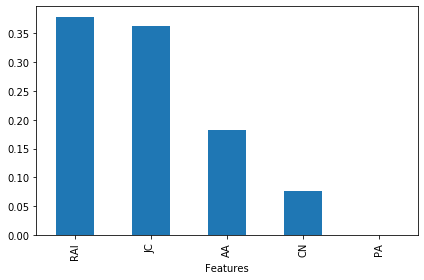

In [67]:
print(evaluate_model(predictions_test,actual_test))
features_importance(columns,rf)

In [68]:
cdf  = test_df
cdf["actual"] = actual_test
cdf["prediction"] = predictions_test
cdf["changedFrom"] = train_df['Target']
print("Total edges",cdf["actual"].count())
print("Total Links",cdf["actual"].sum())
print("Total No Links",cdf[cdf["actual"]==0]["actual"].count())
print("Actual Removed: ",cdf[cdf["changedFrom"]-cdf["actual"] == 1]["changedFrom"].count())
print("Predicted Removed: ",cdf[cdf["changedFrom"]-cdf["prediction"] == 1]["changedFrom"].count())
print("Actual Added: ",cdf[cdf["changedFrom"]-cdf["actual"] == -1]["changedFrom"].count())
print("Predicted Added: ",cdf[cdf["changedFrom"]-cdf["prediction"] == -1]["changedFrom"].count())
print("Actual Unchanged: ",cdf[cdf["changedFrom"]-cdf["actual"] == 0]["changedFrom"].count())
print("Predicted Unchanged: ",cdf[cdf["changedFrom"]-cdf["prediction"] == 0]["changedFrom"].count())
print("Truely added links prediction",cdf[cdf["changedFrom"]-cdf["actual"] == -1][cdf["prediction"]==1]["changedFrom"].count())
print("Truely removal links prediction",cdf[cdf["changedFrom"]-cdf["actual"] == 1][cdf["prediction"]==0]["changedFrom"].count())

Total edges 2248
Total Links 1353
Total No Links 895
Actual Removed:  173
Predicted Removed:  51
Actual Added:  43
Predicted Added:  352
Actual Unchanged:  2032
Predicted Unchanged:  1845


C:\Users\Divay Mohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Truely added links prediction 39


C:\Users\Divay Mohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


Truely removal links prediction 23


## Just prepare test date with the help of lMCI and AD

In [69]:
edges = _extractEdges(node_list,eMCI_mat,0)
train_df = _preparedataset(G_eMCI,G_lMCI,edges)

In [70]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(train_df[columns], train_df['Target'])

C:\Users\Divay Mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [71]:
edges = _extractEdges(node_list,lMCI_mat,0)
test_df = _preparedataset(G_lMCI,G_AD,edges)

In [72]:
predictions_test = rf.predict(test_df[['AA','RAI','PA','JC','CN']])
actual_test = test_df['Target']

In [73]:
predictions_test.sum()

1122

    Measures     Score
0   Accuracy  0.838523
1     Recall  0.934046
2  Precision  0.783844


'Feature importance'

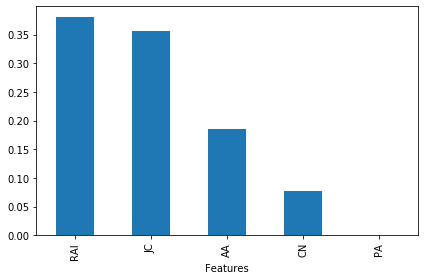

In [74]:
print(evaluate_model(predictions_test,actual_test))
features_importance(columns,rf)

In [75]:
cdf  = test_df
cdf["actual"] = actual_test
cdf["prediction"] = predictions_test
cdf["changedFrom"] = train_df['Target']
print("Total edges",cdf["actual"].count())
print("Total Links",cdf["actual"].sum())
print("Total No Links",cdf[cdf["actual"]==0]["actual"].count())
print("Actual Removed: ",cdf[cdf["changedFrom"]-cdf["actual"] == 1]["changedFrom"].count())
print("Predicted Removed: ",cdf[cdf["changedFrom"]-cdf["prediction"] == 1]["changedFrom"].count())
print("Actual Added: ",cdf[cdf["changedFrom"]-cdf["actual"] == -1]["changedFrom"].count())
print("Predicted Added: ",cdf[cdf["changedFrom"]-cdf["prediction"] == -1]["changedFrom"].count())
print("Actual Unchanged: ",cdf[cdf["changedFrom"]-cdf["actual"] == 0]["changedFrom"].count())
print("Predicted Unchanged: ",cdf[cdf["changedFrom"]-cdf["prediction"] == 0]["changedFrom"].count())
print("Truely added links prediction",cdf[cdf["changedFrom"]-cdf["actual"] == -1][cdf["prediction"]==1]["changedFrom"].count())
print("Truely removal links prediction",cdf[cdf["changedFrom"]-cdf["actual"] == 1][cdf["prediction"]==0]["changedFrom"].count())

Total edges 2248
Total Links 1337
Total No Links 911
Actual Removed:  89
Predicted Removed:  310
Actual Added:  73
Predicted Added:  79
Actual Unchanged:  2086
Predicted Unchanged:  1859


C:\Users\Divay Mohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Truely added links prediction 28


C:\Users\Divay Mohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


Truely removal links prediction 66
